In [45]:
import urllib3
import configparser

import numpy as np
import tensorflow_hub as hub
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import matplotlib.colors as mcolors

from functools import reduce
from wordcloud import WordCloud
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from elasticsearch.helpers import scan
from elasticsearch import Elasticsearch
from wordcloud import get_single_color_func

In [3]:
urllib3.disable_warnings()

config = configparser.ConfigParser()
config.read('../server.ini');

In [4]:
es = Elasticsearch(
    config['ELASTIC']['path'],
    verify_certs=False
)

/opt/homebrew/Caskroom/miniconda/base/envs/thesis/lib/python3.10/site-packages/elasticsearch/connection/http_urllib3.py:209: UserWarning: Connecting to https://localhost:9200 using SSL with verify_certs=False is insecure.
  warnings.warn(


In [5]:
es.info()

{'name': '1bb166804bb3',
 'cluster_name': 'docker-cluster',
 'cluster_uuid': 'm81m9H08RKigCdwIje8C6w',
 'version': {'number': '8.11.0',
  'build_flavor': 'default',
  'build_type': 'docker',
  'build_hash': 'd9ec3fa628c7b0ba3d25692e277ba26814820b20',
  'build_date': '2023-11-04T10:04:57.184859352Z',
  'build_snapshot': False,
  'lucene_version': '9.8.0',
  'minimum_wire_compatibility_version': '7.17.0',
  'minimum_index_compatibility_version': '7.0.0'},
 'tagline': 'You Know, for Search'}

In [6]:
print('Downloading pre-trained embeddings from tensorflow hub...')
tf.disable_eager_execution()
embed = hub.Module('../out/models/universal-sentence-encoder')
text_ph = tf.placeholder(tf.string)
embeddings = embed(text_ph)
print('Done.')

INFO:tensorflow:Saver not created because there are no variables in the graph to restore
Done.


In [7]:
print('Creating tensorflow session...')
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
session = tf.Session(config=config)
session.run(tf.global_variables_initializer())
session.run(tf.tables_initializer())
print('Done.')

Creating tensorflow session...


2023-12-01 00:33:29.543233: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:382] MLIR V1 optimization pass is not enabled
2023-12-01 00:33:30.375899: W tensorflow/c/c_api.cc:305] Operation '{name:'module/string_to_index_11/hash_table/table_init' id:3918 op device:{requested: '', assigned: ''} def:{{{node module/string_to_index_11/hash_table/table_init}} = InitializeTableV2[Tkey=DT_STRING, Tval=DT_INT64, _has_manual_control_dependencies=true](module/string_to_index_11/hash_table, module/Embeddings_en_words, module/string_to_index_11/ToInt64)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Done.


In [8]:
def parse_ground_truth():
    grounds = []
    
    with open('../data/ground.txt') as file:
        lines = [line for line in file.read().split('\n') if line != '']
        
        for ind in range(0, len(lines)-1, 2):
            grounds.append((lines[ind], lines[ind+1]))
    
    return grounds

In [9]:
def get_precision(frequencies, ground_truth):
    raw_pos = []
    positions = []

    for ind1, frequency in enumerate(frequencies):
        for ind2, element in enumerate(frequency):
            if ground_truth[ind1][1].strip().lower() in element.strip().lower():
                raw_pos.append(ind2 + 1)
                positions.append(1 / (ind2 + 1))
                break
        else:
            positions.append(0)

    return (
        sum(positions) / len(positions),
        raw_pos,
        reduce(lambda pre, el: pre + 1 if el != 0 else pre, positions, 0),
        len(positions)
    )

In [10]:
def get_recall(correct, length):
    return correct / length

In [11]:
names = []
vectors = []
grounds_truths = parse_ground_truth()

for ground in grounds_truths:
    tmp = []
    query_vector = session.run(embeddings, feed_dict={text_ph: [ground[0]]}).tolist()[0]
    
    knn_query = {
        'knn': {
            'field': 'document_vector',
            'query_vector': query_vector,
            'k': 5,
            'num_candidates': 3992
        }
    }
    
    results = es.search(index='oa-specifications', body=knn_query)['hits']['hits']
    
    for result in results:
        tmp.append(result['_source']['name'])
        vectors.append(result['_source']['document_vector'])
    
    vectors.append(query_vector)
    names.append(tmp)

In [12]:
prec, pos, correct_pred, preds = get_precision(names, grounds_truths)
rec = get_recall(correct_pred, preds)

print(f'Precision: {str(prec)[:3]}')
print(f'Recall: {str(rec)[:3]}\n')

print('Position in which ground truth was found:')
for ind, position in enumerate(pos):
    print(f'\t"{grounds_truths[ind][1]}" was found at position #{position}')

Precision: 0.5
Recall: 0.9

Position in which ground truth was found:
	"NFL v3" was found at position #1
	"AWS IoT Secure Tunneling" was found at position #4
	"Transport Department" was found at position #4
	"Text Analytics & Sentiment Analysis API | api.text2data.com" was found at position #4
	"MailboxValidator Free Email Checker" was found at position #1
	"Interzoid Country Data Standardization API" was found at position #1
	"Soccer v3 Projections" was found at position #1
	"PolicyClient" was found at position #3
	"NetworkManagementClient" was found at position #2


In [13]:
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'gray', 'orange', 'brown', 'darkorange', 'aqua', 'pink', 'violet', 'magenta', 'indigo']
queries = ['news abou...', 'aws iot s...', 'driving l...', 'sentiment...', 'email mai...', 'country d...', 'football...', 'policy a...', 'client t...', 'weather...']

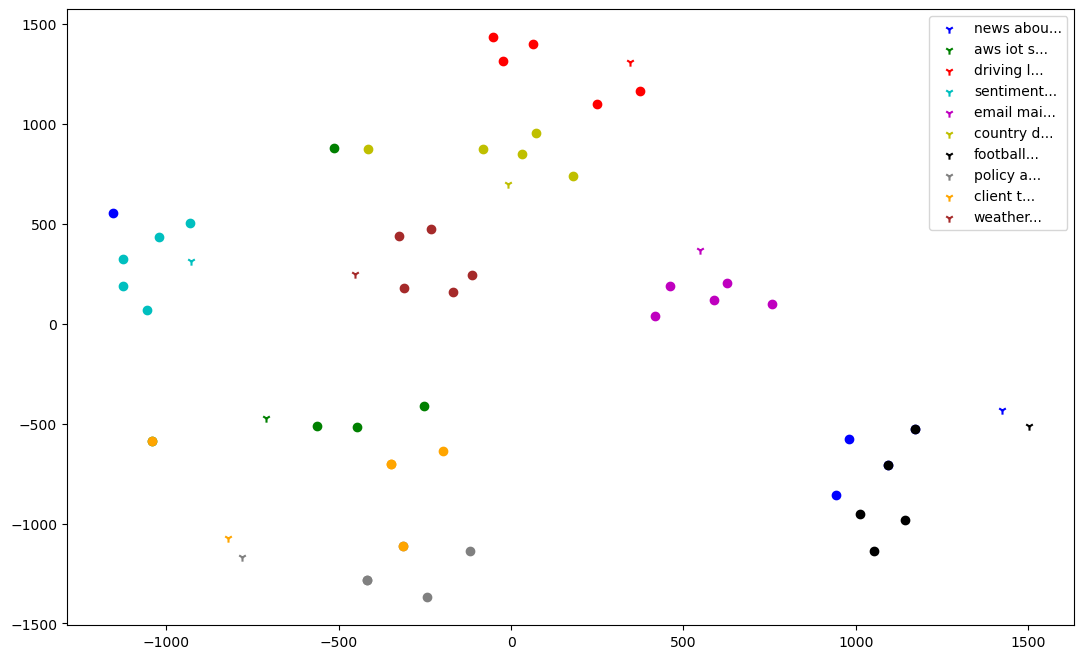

In [14]:
data = TSNE(perplexity=5, n_iter=3000).fit_transform(np.array(vectors))
plt.figure(figsize=(13, 8))

for i in range(0, 60, 6):
    plt.scatter(data[i + 5, 0], data[i + 5, 1], marker='1', color=colors[int(i / 6)], label=queries[int(i / 6)])
    plt.scatter(data[i:i + 5, 0], data[i:i + 5, 1], marker='o', color=colors[int(i / 6)])

plt.legend()
plt.show()

In [31]:
all_vectors = []
all_categories = []
scanner = scan(es, query={'query': {'match_all': {}}}, index='oa-specifications')

for document in scanner:
    if document['_source']['category'] != 'none' and len(document['_source']['category']) > 1:
        all_vectors.append(document['_source']['document_vector'])
        all_categories.append(document['_source']['category'])

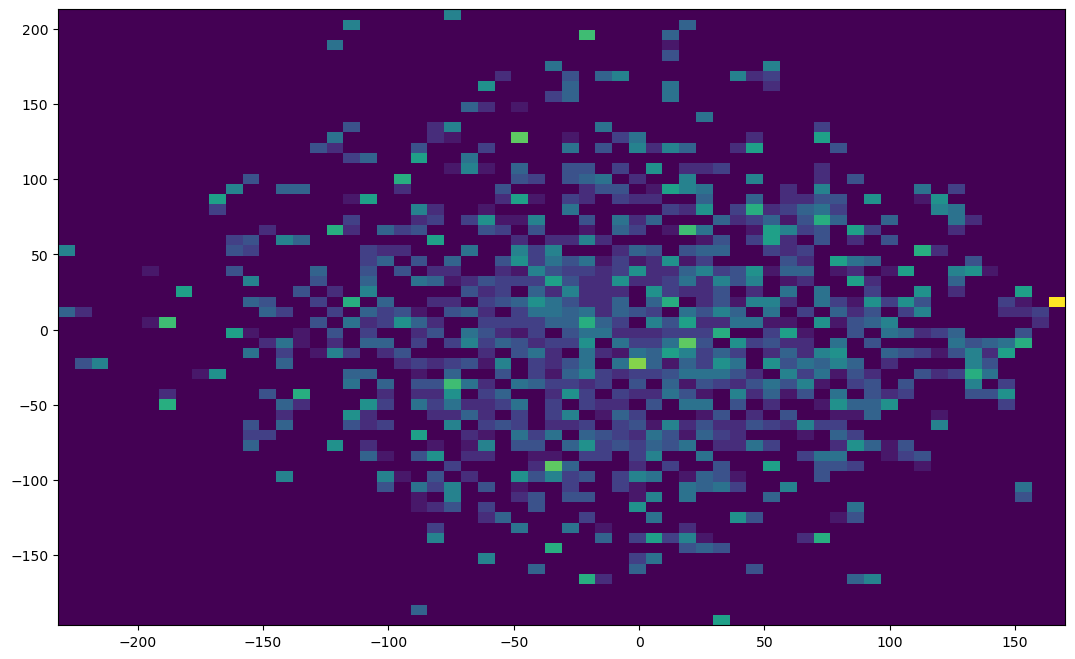

In [32]:
all_data = TSNE(perplexity=5, n_iter=3000).fit_transform(np.array(all_vectors))

plt.figure(figsize=(13, 8))
plt.hist2d([el[0] for el in all_data], [el[1] for el in all_data], bins=60)
plt.show()

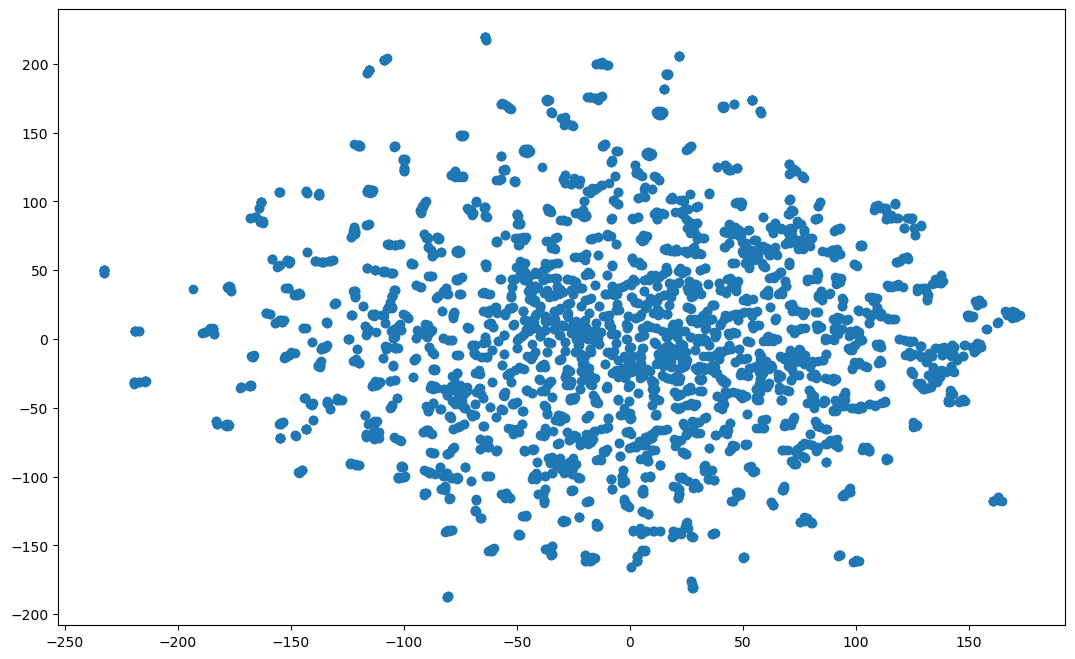

In [131]:
plt.figure(figsize=(13, 8))
plt.scatter([el[0] for el in all_data], [el[1] for el in all_data])
plt.show()

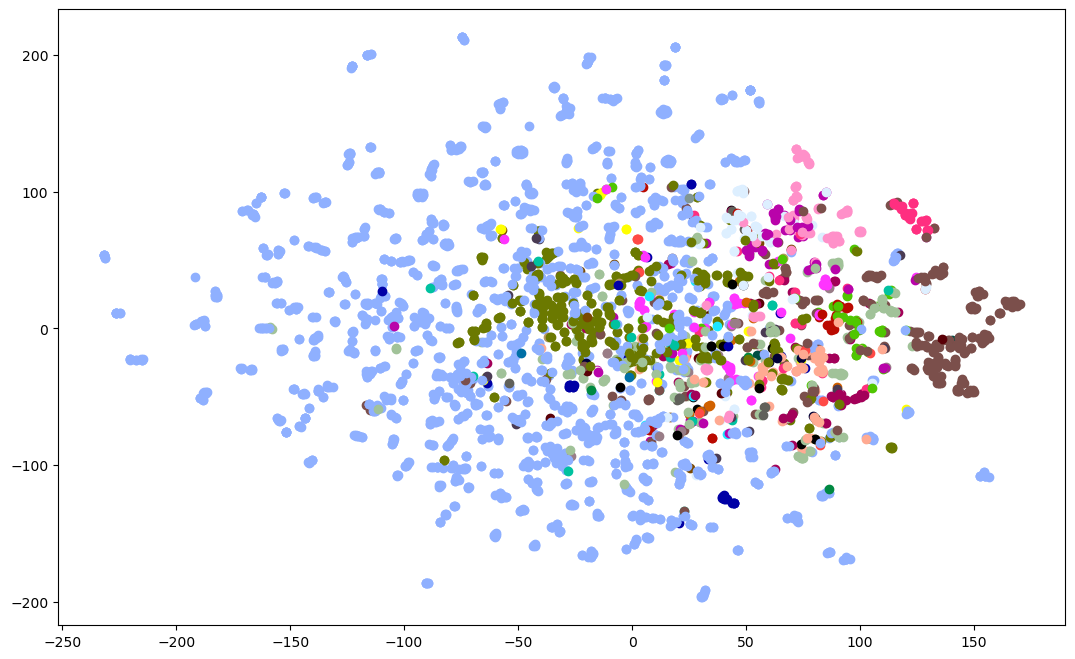

In [105]:
xs = [el[0] for el in all_data]
ys = [el[1] for el in all_data]

plt.figure(figsize=(13, 8))
# colors_new = list(mcolors.CSS4_COLORS.keys())[:33]
colors_new = [
    '#000000', '#FFFF00', '#1CE6FF', '#FF34FF', '#FF4A46', '#008941', '#006FA6', '#A30059',
    '#7A4900', '#0000A6', '#B79762', '#004D43', '#8FB0FF', '#997D87', '#5A0007', '#809693',
    '#FEFFE6', '#4FC601', '#3B5DFF', '#4A3B53', '#FF2F80', '#61615A', '#BA0900', '#6B7900', 
    '#00C2A0', '#FFAA92', '#FF90C9', '#B903AA', '#D16100', '#DDEFFF', '#000035', '#7B4F4B', 
    '#A1C299'
]
one_hot_categories = {category: n for n, category in enumerate(set(all_categories))}
one_hot = [one_hot_categories[category] for category in all_categories]
color_to_word = {colors_new[one_hot_categories[category]]: [category] for category in set(all_categories)}

for index, x in enumerate(xs):
    plt.scatter(x, ys[index], color=colors_new[one_hot[index]])

plt.show()

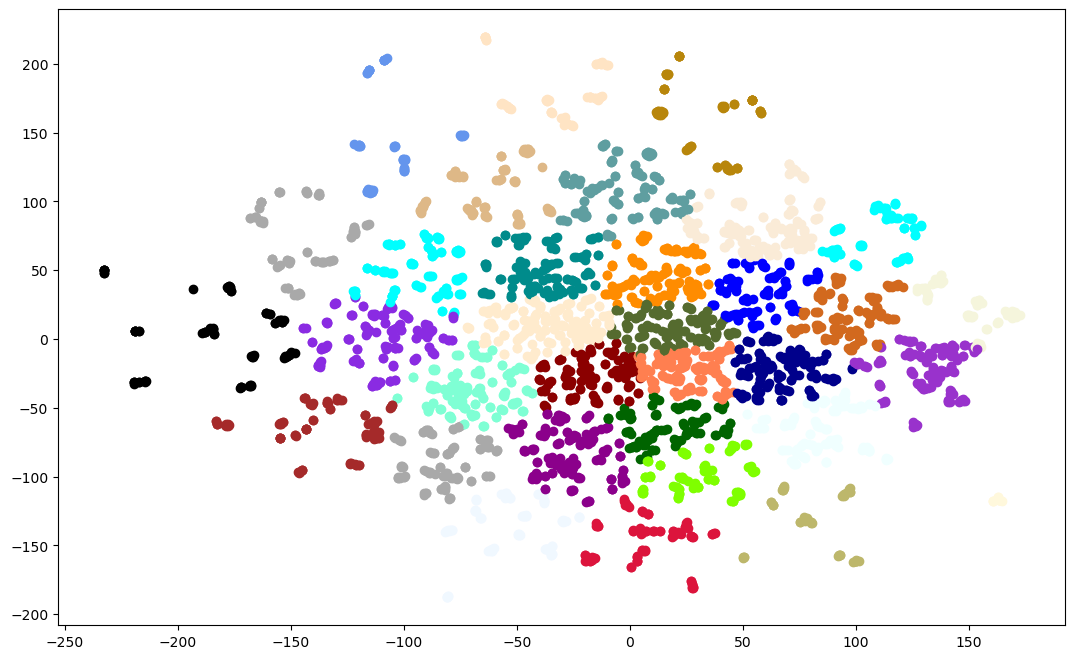

In [150]:
kmeans = KMeans(n_clusters=33, n_init='auto')
kmeans.fit(all_data)

plt.figure(figsize=(13, 8))

for index, x in enumerate(xs):
    plt.scatter(x, ys[index], color=colors_new[kmeans.labels_[index] % 33])
    
plt.show()

<Figure size 1300x800 with 0 Axes>

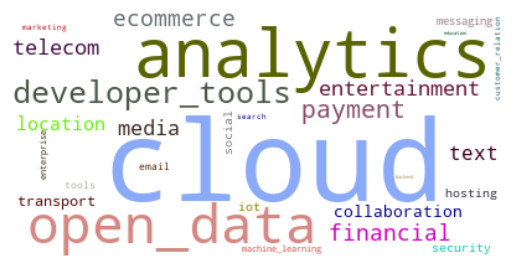

In [171]:
class SimpleGroupedColorFunc(object):
    def __init__(self, color_to_words):
        self.word_to_color = {word: color for (color, word) in color_to_words.items}
        self.default_color = 'grey'
    def __call__(self, word, **kwargs):
        return self.word_to_color.get(word, self.default_color)


class GroupedColorFunc(object):
    def __init__(self, color_to_words):
        self.color_func_to_words = [
            (get_single_color_func(color), set(words))
            for (color, words) in color_to_words.items()
        ]

        self.default_color_func = get_single_color_func('grey')

    def get_color_func(self, word):
        try:
            color_func = next(
                color_func for (color_func, words) in self.color_func_to_words
                if word in words)
        except StopIteration:
            color_func = self.default_color_func

        return color_func

    def __call__(self, word, **kwargs):
        return self.get_color_func(word)(word, **kwargs)

wc = WordCloud(collocations=False, background_color='white').generate(' '.join([category for category in all_categories]))
grouped_color_func = GroupedColorFunc(color_to_word)
wc.recolor(color_func=grouped_color_func)

plt.figure(figsize=(13, 8))
plt.figure()
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()